# Preparation

In [70]:
import numpy as np
from astropy.time import Time
from astroquery.simbad import Simbad
from astroplan import Observer
from astropy.coordinates import EarthLocation
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
from matplotlib.ticker import FixedLocator
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
# import datetime
from datetime import datetime, timedelta
from multiprocessing import Pool
from scipy.interpolate import griddata
import pytz
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import inspect

In [48]:
WelcomeMessage = """
Welcome to the AstroObjectHelperPipeline! This code is still in experimental mode! This is a short introduction to the code with all the relevant data.
First of all, you will need to define your observation location. To do this, please define the variables `Lon` (Longitude in degrees), `Lat` (Latitude in degrees) and `ele` (elevation in metres).
If you have your coordinates in any other format please us the helper functions below to transform to degrees!
Next call the function `TelescopeData` and input the necessary parameters of your telescope so that other functions work! If there is a typo in the variable names or
if you just want to experiment with the standard values, the geographic location used without input is the Dr. Remeis Observatory in Bamberg, Germany as the seat
of the astronomical institute of the Friedrich-Alexander University Erlangen-Nuremberg with data of Lon: 10.88846, Lat: 49.88474, ele: 282 (°, °, m).

Now let's get to business. Below is a list of all relevant functions and a short description. We wish you a lot of fun using the code!

dms_to_deg, deg_to_dms, hms_to_deg, H_to_hms, deg_to_rad, rad_to_deg :  These all are transformations from one angle system to another
Simbad_extraction : This function is called when you want to create your own list of objects with data. It conducts a query of Simbad and saves the data into a .txt file. We recommend using the provided IC, Messier and NGC text files!
AdvancedViewer : This function plots the altitude and the azimuth with respect to time of day or rather night. It also shows you the object in the FOV of the telescope.
PathViewer : This function plots the paths of the best observable objects on the night sky. The coloured paths are the TOP 5 objects.
TimeViewer : This function plots the best observation time and the respective maximum height of the object, both with respect to day in a year.
Map : This function plots a map (RA-DEC) of objects on the night sky.
color_map : This function plots a colormap of points (coordinates being RA-DEC), where the color indicates the number of minutes, an object with certain coordinates would be above 30° alltitide in the observation night.

Now you are set to start, don't forget to write the variables and then enjoy!
"""

def getStarted():
    print(WelcomeMessage)

# Helper Functions

In [25]:
def dms_to_deg(d: float, m: float, s: float) -> float:
    """ This function takes coordinates in the format of degree:minute:second and calculates into decimal degrees.
    
    Parameters
    ----------
    d : float, Degrees
    m : float, Minutes
    s : float, Seconds
    
    :return (float) degrees: d:m:s in decimal degrees"""
    if d == 0:
        degrees =(np.abs(d) + m/60 + s/3600)
    else:
        degrees = (np.abs(d) + m/60 + s/3600)* np.sign(d)
    return degrees

def deg_to_dms(degrees: float) -> tuple[int, int, float]:
    """ This function takes coordinates in the format of decimal degrees and calculates into degree:minute:second.
    
    Parameters
    ----------
    degrees : float, Angle in degrees
    
    Returns
    ----------
    d : int, Degrees
    m : int, Minutes
    s : float, Seconds
    """
    deg=np.abs(degrees)
    d=np.round(np.floor(deg)*degrees/deg,0)
    m=np.round(np.floor(((deg-np.abs(d))*60)),0)
    s=np.round(((deg-np.abs(d)-(m/60))*3600),2)
    return d,m,s

def hms_to_deg(h: float, m: float, s: float) -> float:
    """ This function takes coordinates in the format of hours:minute:second and calculates into decimal degrees.
    Parameters
    ----------
    h : float, Hours
    m : float, Minutes
    s : float, Seconds

    Returns
    ----------
    degrees : float, h:m:s in decimal degrees
    """
    if h == 0:
        degrees = 15*(np.abs(h) + m/60 + s/3600)
    else:
        degrees = 15*(np.abs(h) + m/60 + s/3600)*np.sign(h)
    return degrees

def H_to_hms(H: float) -> tuple[int, int, float]:
    """ This function takes coordinates in the format of decimal hours and calculates into hours:minutes:seconds.
    
    Parameters
    ----------
    H : float, Hours
        
    Returns
    ----------
    h : int, Hours
    m : int, Minutes
    s : float, Seconds
    """
    h=np.floor(H)
    m=np.floor((H-h)*60)
    s=np.round((H-h-(m/60))*3600,2)
    return h,m,s

def deg_to_rad(degrees: float) -> float:
    """This function takes degrees and calculates into radians.
    
    Parameters
    ----------
    degrees : float, Angle in degrees
    
    Returns
    ----------
    rad : float, Angle in radians
    """
    rad = degrees * np.pi/180
    return rad

def rad_to_deg(rad: float) -> float:
    """This function takes radians and calculates into degrees.
    
    Parameters
    ----------
    rad : float, Angle in radians

    Returns
    ----------
    degrees : float, Converted angle
    """
    degrees = rad * 180/np.pi
    return degrees

In [52]:
# Longitude of the observatory in dms, standard value is the Dr. Karl Remeis Observatory in Bamberg (FAU)
d_1 = 10
m_1 = 53
s_1 = 18

# Latitude of the observatory in dms, standard value is the Dr. Karl Remeis Observatory in Bamberg (FAU)
d_2 = 49
m_2 = 53
s_2 = 4

Lon = dms_to_deg(d_1,m_1,s_1)
Lat = dms_to_deg(d_2,m_2,s_2)
ele = 281 # Elevation of the observatory in metres, standard value is the Dr. Karl Remeis Observatory in Bamberg (FAU)

print(Lon, Lat)

10.888333333333334 49.88444444444444


In [56]:
def earth_rotation_angle(zeit_jd):
    """Creates Earth's Rotation Angle (ERA) for a given time, which is needed to transform between equatorial and horizontal coordinate systems.
    
    Parameters
    ----------
    zeit_jd : float, Time in Julian date

    Returns
    ----------
    theta : float, angle
    """        
    D_U = zeit_jd-2451545.0
    theta_0 = 360 * (0.7790572732640 + 1.00273781191135448*D_U)
    theta = theta_0 % 360
    return theta

def rotation_matrix_z(angles):
    """Creates the roation matrix for the z-axis, which is needed to transform between equatorial and horizontal coordinate systems.
    
    Parameters
    ----------
    angles : float or array

    Returns
    ----------
    matrices : array, rotation matrix
    """ 
    if isinstance(angles, (int, float)):
        angles = [angles]
    matrices = []
    for t_p in angles:
        R_z = np.array([[np.cos(t_p), np.sin(t_p), 0],[-np.sin(t_p), np.cos(t_p), 0],[0, 0, 1]])
        matrices.append(R_z)
    return matrices

pi=np.pi

def rotation_matrix_y(phi):
    """Creates the roation matrix for the y-axis, which is needed to transform between equatorial and horizontal coordinate systems.
    
    Parameters
    ----------
    phi : float or array, angle

    Returns
    ----------
    matrices : array, rotation matrix
    """ 
    R_y = np.array([[np.sin(phi),0,-np.cos(phi)],[0,1,0],[np.cos(phi),0,np.sin(phi)]])
    return R_y
    
R_y=rotation_matrix_y(deg_to_rad(Lat))
diag = np.array([[-1,0,0],[0,1,0],[0,0,1]])

def azimut_hoehe(zeit_jd: float,ra_deg: float,dec_deg: float) -> tuple[float, float]:
    """This function converts equatorial coordinates (RA,DEC) into horizontal corrdinates (Alt,Az) for a given time.
    
    Parameters
    ----------
    zeit_jd : float, Time in Julian date
    ra_deg : flaot, Right ascension in degrees
    dec_deg : float, Declination in degrees

    Returns
    ----------
    Azimuth : float, Azimuth of given position in degrees
    Altitude : float, Altitude of given position in degrees
    """    
    ra=deg_to_rad(ra_deg)
    dec=deg_to_rad(dec_deg) 
    ERA = deg_to_rad(earth_rotation_angle(zeit_jd)) + deg_to_rad(Lon)
    R_z = rotation_matrix_z(ERA)
    R = np.array([[np.cos(ra)*np.cos(dec)],[np.sin(ra)*np.cos(dec)],[np.sin(dec)]])
    M = diag@(R_y@(R_z@R))
    H = np.arcsin(M[:,2,:])
    A = np.arctan2(M[:,1,:],M[:,0,:])
    H_deg = rad_to_deg(H)
    A_deg = rad_to_deg(A)
    return A_deg, H_deg

def zenith_distance(Alltitude):
    z=90-Alltitude
    return z

# Creating List of Objects for Messier, NGC and IC

In [28]:
# Clear cache to avoid stale results
Simbad.clear_cache()

# Configure Simbad query to include required fields
custom_simbad = Simbad()
custom_simbad.add_votable_fields('main_id', 'ra', 'dec', 'V', 'dim', "ids","morph_type")

Messier_list = ["M" + str(i) for i in range(1,109)]
NGC_list = ["NGC" + str(i) for i in range(1,7841)]
IC_list = ["IC" + str(i) for i in range(1,5387)]

def extract_messier_name(object_ids):
    """Checks if an object's ID list contains a Messier name.

    Calls an object -> splits the name using the delimiter '|' used by SIMBAD
    -> checks if there is an "Messier" or "M " name in the list -> filters the object out of the list

    Parameters
    ----------
    object_ids : list, List of object IDs
    """
    if object_ids is None:
        return None  # No IDs available

    for id_str in object_ids.split('|'):  # SIMBAD separates IDs with '|'
        id_str = id_str.strip()
        if id_str.startswith("Messier") or id_str.startswith("M "):
            return id_str  # Return the first found Messier name
    
    return None

def extract_NGC_name(object_ids):
    """Check if an object's ID list contains a NGC name.
    
    Calls an object -> splits the name using the delimiter '|' used by SIMBAD
    -> strips the white spaces -> checks if there is an "NGC" -> filters the object out of the list
    
    Parameters
    ----------
    object_ids : list, List of object IDs
    """
    if object_ids is None:
        return None  # No IDs available

    for id_str in object_ids.split('|'):  # SIMBAD separates IDs with '|'
        id_str = id_str.strip() # Extra Info: NGC always has one space between NGC XXXX. However, if the number is less than four digits, spaces are added to compensate, so that NGC  XXX is in the same position as NGC   XX and NGC    X
        if id_str.startswith("NGC"):
            return id_str.replace(" ", "")  # Return the first found NGC name
    
    return None

def extract_IC_name(object_ids):
    """Check if an object's ID list contains a IC name.
    
    Calls an object -> splits the name using the delimiter '|' used by SIMBAD
    -> strips the white spaces -> checks if there is an "IC" -> filters the object out of the list
    
    Parameters
    ----------
    object_ids: list, List of object IDs
    """
    if object_ids is None:
        return None  # No IDs available

    for id_str in object_ids.split('|'):  # SIMBAD separates IDs with '|'
        id_str = id_str.strip() # Extra Info: IC always has one space between IC XXXX. However, if the number is less than four digits, spaces are added to compensate, so that IC  XXX is in the same position as IC   XX and IC    X
        if id_str.startswith("IC"):
            return id_str.replace(" ", "") # Return the first found NGC name
    
    return None

 
def Simbad_extraction(objects, name, batch_size=200):
    """This function conducts a query of SIMBAD. It pulls the data for RA, DEC, dimensions, flux and morphological type. Then it creates a list of all objects. The list of objects is saved as ```[name].txt```
    
    Parameters
    ----------
    objects : list, A list of all objects
    name : str, Name of list to be saved as `[name].txt`
    batch_size : int, size over which loop iterates

    Returns
    ----------
    data_npar : 6darray, NumPy array consisting of data of the filtered objects
    """
    data = []

    # Creates a batch of objects which are then queried. After the batch is complete, new batch is created.
    for i in range(0, len(objects), batch_size):
        batch = objects[i:i + batch_size]
        result_table = custom_simbad.query_objects(batch)

        if result_table is None:
            print(f"No results found for batch {i // batch_size + 1}")
            continue

        for j, obj in enumerate(batch):
            try:
                # Extract RA and DEC
                ra_values = result_table['ra'][j]
                dec_values = result_table['dec'][j]

                magnitude = result_table["V"][j] if "V" in result_table.colnames else None
                
                # Extract galaxy dimensions (major/minor axis)
                major_axis = result_table["galdim_majaxis"][j] if "galdim_majaxis" in result_table.colnames else None
                minor_axis = result_table["galdim_minaxis"][j] if "galdim_minaxis" in result_table.colnames else None

                matched_ID = result_table["ids"][j] if "ids" in result_table.colnames else None
                messier_name = extract_messier_name(matched_ID)
                NGC_name = extract_NGC_name(matched_ID)
                IC_name = extract_IC_name(matched_ID)

                morph_type = result_table["morph_type"][j] if "morph_type" in result_table.colnames else None
                if np.ma.is_masked(ra_values) or np.ma.is_masked(dec_values):
                    continue

                # Filter for name lists. If one of these is true, it means that an object has double names and is filtered out of the list. For more infos see documentation of the functions NGC_name, messier_name and IC_name.
                if obj in NGC_list:
                    if NGC_name != obj:
                        continue
                    if messier_name:
                        continue
                elif obj in IC_list:
                    if IC_name != obj:
                        continue

                # Append only if all values exist
                data.append((obj, ra_values, dec_values, magnitude, major_axis, minor_axis, morph_type))

            except Exception as e:
                print(f"Error processing {obj}: {e}")

    data_npar = np.array(data, dtype=object)

    # Saves the numpy array as a file under the name [name].txt as provided in the function
    np.savetxt(name, data_npar)
    
    return data_npar

def load_variable_column_file(filename: str):
    """
    This function loads a ```.txt``` file object lists. Because of the function :obj:`Simbad_extraction` some objects do not have values for their morphological type. This function pads those cells and adds a `NaN` so that the resulting table is consistent.

    Parameters
    ----------
    filename : str, Name of the file in form of `[NAME_OF_FILE].txt`

    Returns
    ----------
    data_padded_nparr : 7darray str, Padded data from `.txt` file as NumPy array with elements as strings.
    """

    with open(filename, "r") as f:
        lines = [line.strip().split() for line in f if not line.startswith("#")]

    # Find the maximum number of columns in the file
    max_cols = max(len(line) for line in lines)

    # Ensure all rows have the same number of columns by padding missing values
    data_padded = [line + ["NaN"] * (max_cols - len(line)) for line in lines]

    # Convert to NumPy array
    data_padded_nparr = np.array(data_padded, dtype=str)
    return data_padded_nparr

messier_arr = load_variable_column_file("Messier.txt")
NGC_arr = load_variable_column_file("NGC.txt")
IC_arr = load_variable_column_file("IC.txt")


data_arr = np.vstack((messier_arr,NGC_arr,IC_arr))

In [29]:
Only_Galaxies = 1

def Galaxies(Objects):
    """
    This function filters a list of objects by the condition of "Galaxy".

    Parameters
    ----------
    Objects : list, List of objects

    Returns
    ----------
    Objects_gal : array str, List of all galaxies
    """
    no_gal = []

    is_galaxy = Objects[:, -1] != "NaN"

    Objects_gal = Objects[is_galaxy]

    Objects_not_gal = Objects[~is_galaxy]

    return Objects_gal, Objects_not_gal

if Only_Galaxies == 1:
    data_arr_2 = Galaxies(data_arr)[0]
else:
    data_arr_2 = np.vstack((messier_arr,NGC_arr,IC_arr))

In [ ]:
fl = 750
# Ap = 150
Ps = 4.30
x_ax = 5184
y_ax = 3456
Dia = np.sqrt((x_ax)**2+(y_ax)**2)

def TelescopeData(FocalLength: float, pixelsize: int, x_Pixels: int, y_Pixels: int):
    """
    This function takes your telescope data and saves it as a global variable. To omit using this function you can just declare the following variables:
    ```
    fl = 750
    Ps = 4.30
    x_ax = 5184
    y_ax = 3456
    ```
    with the variables corresponding to those needed for the function. The values provided here are the standard values

    Parameters
    ----------
    FocalLength : float, Focal Length of the telescope
    pixelsize : float, pixel size of your sensor in μm
    x_Pixels : int, number of pixels in your camera on the length
    y_Pixels : int, number of pixels in your camera on the width
    """
    global fl
    fl = FocalLength
    global Ps
    Ps = pixelsize
    global x_ax
    x_ax = x_Pixels
    global y_ax
    y_ax = y_Pixels
    global Dia
    Dia = np.sqrt((x_ax)**2+(y_ax)**2)

def Fov(L):
    return (206.2648 * (Ps/fl) * L)/60


FOV = Fov(Dia)

x_FOV = Fov(x_ax)
y_FOV = Fov(y_ax)

min_frac = 0.1

remove_nan = 1

def safe_convert(val):
    try:
        return float(val)
    except ValueError:
        return np.nan

def ratio(object_arr):
    """
    This function filters the array with objects with respect to their ratio to the diagonal of the FOV. If the major or the minor axis of an object are larger than the set hurdle (standard is `0.1*x_FOV` and `0.1*y_FOV` respectively) they are left in the array, else they are filtered out.

    Parameters
    ----------
    object_arr : array, array of objects

    Returns
    ----------
    object_arr[mask] : array, masked array of objects
    """
    maj_ax = np.array([safe_convert(x) for x in object_arr[:,4]])
    min_ax = np.array([safe_convert(x) for x in object_arr[:,5]])

    mask = (maj_ax >= min_frac * x_FOV) | (min_ax >= min_frac * y_FOV)

    #mask = (np.isnan(maj_ax) | (maj_ax>=min_frac*x_FOV)) & (np.isnan(min_ax) |  (min_ax>=min_frac*y_FOV))

    if remove_nan:
        mask = mask & ~np.isnan(maj_ax) & ~np.isnan(min_ax)

    return object_arr[mask]

data_FOV = ratio(data_arr_2)

def Ratio(object_row):
    """
    This function calculates the percentage the objects diagonal takes in relation to the diagonal of the FOV.

    Parameters
    ----------
    object_row : array, array of object data

    Returns
    ----------
    Diagonal/FOV : float, percentage
    """
    Diagonal = np.sqrt(float(object_row[4])**2+float(object_row[5])**2)
    return Diagonal/FOV

In [31]:
# Alltitude maximal if ra_deg = ERA + Lambda

def min_zenith_distance(dec_deg):
    dec = deg_to_rad(dec_deg)
    phi = deg_to_rad(Lat)
    #print(phi,dec)
    H_ex_1 = np.arcsin(np.cos(phi-dec))
    #H_ex_2 = np.arcsin(np.cos(phi+dec+np.pi)+np.cos(phi-dec+np.pi))
     #np.arcsin((-2*np.cos(dec+phi)+2*np.cos(dec-phi)+np.cos(dec+phi)+np.cos(-dec+phi)+np.cos(dec-phi)+np.cos(-dec-phi))/4)
    H_ex_2 = np.arcsin((-2*np.cos(dec+phi)+2*np.cos(dec-phi)+np.cos(dec+phi+np.pi)+np.cos(-dec+phi+np.pi)+np.cos(dec-phi+np.pi)+np.cos(-dec-phi+np.pi))/4)
    H_EX_1 = rad_to_deg(H_ex_1)
    H_EX_2 = rad_to_deg(H_ex_2)
    #print(H_EX_1,H_EX_2)
    if H_ex_1 > H_ex_2:
        z = zenith_distance(H_EX_1)
    else:
        z = zenith_distance(H_EX_2)
    return z

#arcsin((-2*cos(dec+phi)+2*cos(dec-phi)+cos(dec+phi+pi)+cos(-dec+phi+pi)+cos(dec-phi+pi)+cos(-dec-phi+pi))/4)

min_zen_dis = []

for n in range(len(data_FOV[:,1])):
    z = min_zenith_distance(data_FOV[n,2].astype(float))
    min_zen_dis.append(z)
Z_s = np.array(min_zen_dis)

#deleting all Objects which never reach 60° 

baseline = 40

indices_to_del = []

for n in range(len(Z_s)):
    if float(Z_s[n].item()) >baseline:
        indices_to_del.append(n)
Z_g = np.delete(Z_s,indices_to_del,0)
#print(Z_g)
data_min_h = np.delete(data_FOV, indices_to_del,0)




# Time

In [32]:
location = EarthLocation.from_geodetic(lon= Lon* u.deg, lat = Lat* u.deg, height = ele*u.m)
observer = Observer(location=location, timezone="Europe/Berlin")

selected_date = "2025-03-08"
date_time = Time(selected_date)
start_time_utc = observer.sun_set_time(date_time, which="nearest",horizon=-12 * u.deg)
end_time_utc = observer.sun_rise_time(date_time, which="nearest",horizon=-12 * u.deg)

cest_tz = pytz.timezone("Europe/Berlin")
start_time = start_time_utc.to_datetime(timezone=cest_tz)
end_time = end_time_utc.to_datetime(timezone=cest_tz)

start_time_wtz = start_time.astimezone(cest_tz)
end_time_wtz = end_time.astimezone(cest_tz)

delta_T = (end_time - start_time).total_seconds() / (24 * 3600)
p = int(delta_T*1440 + 1)

T = np.linspace(0,delta_T,p) 


utc_time = start_time.astimezone(pytz.utc)
Zeit_Nacht = Time(utc_time).jd
Zeit_Nacht_T = Zeit_Nacht + T

keep = []
more_del=[]


m = 30 # Baseline altitude above which DSO should be for an extended period. 

num = 120 # Duration of position over baseline altitude

def min_h(data):
    """
    This function filters the array with objects with respect to their ratio to the diagonal of the FOV. If the major or the minor axis of an object are larger than the set hurdle (standard is `0.1*x_FOV` and `0.1*y_FOV` respectively) they are left in the array, else they are filtered out.

    Parameters
    ----------
    object_arr : array, array of objects

    Returns
    ----------
    object_arr[mask] : array, masked array of objects
    """
    for n in range(len(data[:,0])):
        if np.sum((azimut_hoehe(Zeit_Nacht_T,data[n,1].astype(float),data[n,2].astype(float)))[1] > m) >=num:
            keep.append(n) 
        else: 
            more_del.append(n)

    return np.delete(data,more_del,0)

data_fin = min_h(data_min_h)

minutes = np.linspace(0,p,p)
time_data_wtz = [start_time + timedelta(minutes=int(minute)) for minute in minutes]



start_time = start_time_wtz.replace(tzinfo=None)
end_time = end_time_wtz.replace(tzinfo=None)

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
 
time_data = [dt.replace(tzinfo=None) for dt in time_data_wtz]

Start Time: 2025-03-07 19:12:58.022736
End Time: 2025-03-08 05:31:45.839217


# Advanced Viewer

In [33]:
def time_over_x(data):
    data_30 = []
    for n in range(len(data[:,0])):
        N = np.sum((azimut_hoehe(Zeit_Nacht_T,data[n,1].astype(float),data[n,2].astype(float)))[1] > m)
        data_30.append(N) 

    data_30_arr = np.array(data_30, dtype = float)
    return np.append(data, data_30_arr[:, None], axis=1)

sorted_data_30 = time_over_x(data_fin)
final_best = np.array(sorted(sorted_data_30, key=lambda x: ( float(x[-1]), float(x[4])), reverse=True),dtype = object)

In [46]:
def AdvancedViewer(k: int):
    """
    This functions prints plots three diagrams for each object: 1. a time-altitude diagram, 2. a time-azimuth and 3. size in FOV. The ratio of the diagonals (object:FOV) is displayed in percent.
    
    Parameters
    ----------
    k : no. of objects being plotted 
    
    """

    k = min(k, len(final_best[:, 0]))
    for n in range(k):
        H = (azimut_hoehe(Zeit_Nacht_T,float(final_best[n,1]),float(final_best[n,2])))[1]
        a = (azimut_hoehe(Zeit_Nacht_T,float(final_best[n,1]),float(final_best[n,2])))[0]
        A = [x + 360 if x<0 else x for x in a]

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

        # Plot Altitude (H) on the first axis
        ax1.plot(time_data, H, label='Altitude')
        ax1.plot(time_data, np.linspace(30, 30, p), label='30° Reference')
        ax1.set_title(f"{final_best[n, 0]} - Altitude")
        ax1.set_ylabel('Altitude in °')
        ax1.set_xlim(start_time,end_time)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
        ax1.legend()
        ax1.grid()
       
        
        # Plot Azimuth (A) on the second axis
        ax2.plot(time_data, A,"-",label='Azimuth')
        ax2.set_title(f"{final_best[n, 0]} - Azimuth")
        ax2.set_ylabel('Azimuth in °')
        ax2.set_xlim(start_time,end_time)
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax2.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
        ax2.legend()
        ax2.grid()

        ellipse = Ellipse((0,0),width=float(final_best[n,4])/x_FOV,height=float(final_best[n,5])/y_FOV,angle = 0, alpha = 0.5)

        ax3.add_patch(ellipse)
        ax3.set_xlim(-0.5,0.5)
        ax3.set_ylim(-0.5,0.5)
        ax3.set_title(f"Size of {final_best[n,0]} in FOV")
        ax3.set_aspect(aspect=y_ax/x_ax)
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])

        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        fig.text(0.33,0.91,f"{np.float64(Ratio(final_best[n]))*100:.3f} %")

        plt.tight_layout()
        plt.show()

# Path Viewer

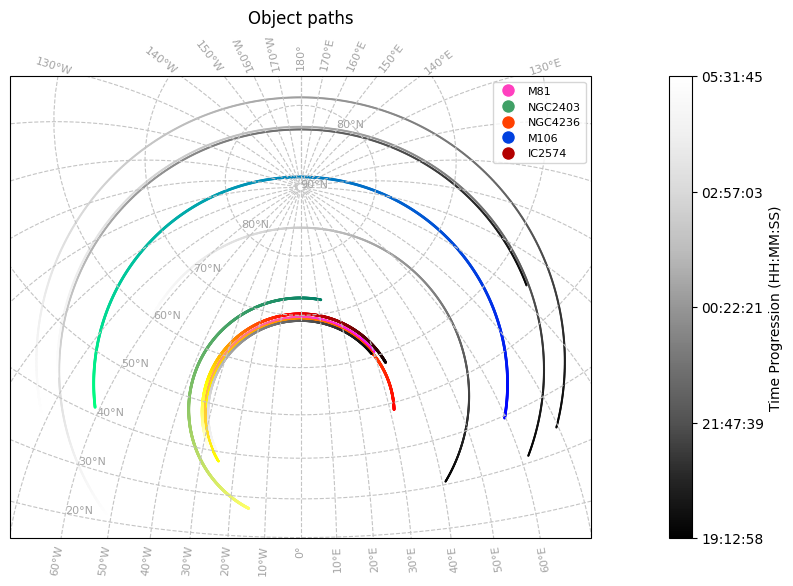

In [35]:
def PathViewer():
    """
    This function plots the paths of the objects from `final_best` onto a stereographic projection of the sky. The paths of the five best objects are coloured, the rest ist b/w. The start and end time are defined by variables `start_time` and `end_time`.
    """

    # Convert start & end time to Julian Date
    start_jd = Time(start_time).jd
    end_jd = Time(end_time).jd

    # Generate time steps in Julian Date format
    time_frame = np.linspace(start_jd, end_jd, 1000)

    # Create the Stereographic projection using Cartopy
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.Stereographic()})
    ax.set_title("Object paths")

    legend_elements = []  # Speichern Sie Element für die Legende

    for n in range(10):
        if n in range(5):
            colors = ["spring", "summer", "autumn", "winter", "hot"]
            cmap = plt.get_cmap(colors[n])
            size = 1  # Größere Punkte für die ersten 5
            alpha = 1.0  # Voll opak für die ersten 5
            label = f"Object {final_best[n, 0]}"  # Label für Legende
        else:
            cmap = plt.get_cmap("Greys_r")
            size = 0.25  # Kleinere Punkte für die anderen
            alpha = 1  # Teilweise transparent für die anderen
            label = None  # Kein Label für die anderen

        A, H = azimut_hoehe(time_frame, float(final_best[n, 1]), float(final_best[n, 2]))
        norm = Normalize(vmin=start_jd, vmax=end_jd)
        
        # Scatter plot für Punkte
        ax.scatter(A, H, c=norm(time_frame), cmap=cmap, s=size, transform=ccrs.PlateCarree(), alpha=alpha, label=label)
        
        # Legendenelement speichern
        if n < 5:  # Nur für die ersten 5 hinzufügen
            legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f"{final_best[n, 0]}", markerfacecolor=cmap(0.25), markersize=10))

    # Hinzufügen von Gitterlinien alle 10°
    gl = ax.gridlines(draw_labels=True, linestyle="--", color = "#c4c4c4")
    gl.xlocator = FixedLocator(np.arange(-180, 181, 10))  # Längenlinien alle 10°
    gl.xformatter = LongitudeFormatter()
    gl.ylocator = FixedLocator(np.arange(-90, 91, 10))    # Breitengradlinien alle 10°

    # Aktivieren aller Labels
    gl.xlabel_style = {'size': 8, 'color': '#a4a4a4'}
    gl.ylabel_style = {'size': 8, 'color': '#a4a4a4'}
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Manually place altitude (latitude) labels near 0° longitude
    for lat in range(20, 91, 10):  # Every 10° from 10° to 90°
        ax.text(-60, lat, f"{lat}°N", transform=ccrs.PlateCarree(),
                ha="left", va="baseline", fontsize=8, color="#a4a4a4", rotation=0)

    # Create the color scale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", pad=0.1)
    tick_labels_jd = np.linspace(start_jd, end_jd, num=5)
    cbar.set_ticks(tick_labels_jd)
    cbar.set_ticklabels([Time(jd, format='jd').datetime.strftime("%H:%M:%S") for jd in tick_labels_jd])
    cbar.set_label("Time Progression (HH:MM:SS)")

    # Legende mit richtigen Farben für die Punkte
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

    plt.show()

PathViewer()

# Time Viewer

In [36]:
object_map = {name: idx for idx, name in enumerate(data_arr[:, 0])}

def get_row_by_name(name):
    """Get the row index for a given object name."""
    return object_map.get(name, None)

def TimeViewer(object_name: str):
    """
    This function plots the maximal altitude and the time of it with respect to the day of the year. The flat lines of the maximal time are data points beyond the 18:00 and 06:00 border.

    Parameters
    ----------
    objects_name: str, Name of the object to be observed in form of `"M101"`. Watch out for spelling and capital letters, else it may fail.
    
    """
    dt_1 = datetime(2025, 1, 1, 18, 0, 0)
    cest_tz = pytz.timezone("Europe/Berlin")
    cest_time_1 = cest_tz.localize(dt_1)

    utc_time_1 = cest_time_1.astimezone(pytz.utc)
    Zeit_start = Time(utc_time_1).jd

    day_arr = np.linspace(0, 0.5, 1001)
    max_time = []
    max_height = []

    object_idx = get_row_by_name(object_name)

    if object_idx is not None:
        for n in range(365):
            Day = Zeit_start + day_arr + n
            H_object = (azimut_hoehe(Day, data_arr[object_idx, 1].astype(float), data_arr[object_idx, 2].astype(float)))[1]
            max_time_loop = np.argmax(H_object)
            max_loop = np.max(H_object)
            max_height.append(max_loop)
            time_loop = np.linspace(0, 12, 1001)[max_time_loop]
            max_time.append(time_loop)

        max_time_arr = np.array(max_time)
        max_height_arr = np.array(max_height)
        year = np.linspace(1, 365, 365)

        def convert_time(value):
            """Converts time (0-12) to 18:00-6:00 format."""
            hours = (value + 18) % 24
            return f"{int(hours):02d}:00"

        month_days = [0] + np.cumsum([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]).tolist()
        month_labels = [calendar.month_name[i] for i in range(1, 13)]

        # Plotting
        fig, ax1 = plt.subplots()
        line1, = ax1.plot(year, max_time_arr, color='#1f77b4', label="Max Time")
        ax1.set_ylabel("Time")
        ax1.set_xlabel("Months of the Year")
        ax1.set_xlim(0,365)
        ax1.set_title(object_name)

        ax1.set_yticks(np.linspace(0, 12, 7))
        ax1.set_yticklabels([convert_time(tick) for tick in np.linspace(0, 12, 7)])

        ax1.set_xticks(month_days[:-1])
        ax1.set_xticklabels(month_labels)

        for day in month_days[1:-1]:  # Skip the first (0) and last (end of the year)
            ax1.axvline(x=day, color='gray', linestyle='--', linewidth=0.7)

        ax2 = ax1.twinx()
        line2, = ax2.plot(year, max_height_arr, color='#ff7f0e', label="Max Height")
        ax2.set_ylabel("Altitude")


        # ax1.set_ylim(-0.5,12.5)
        # ax2.set_ylim(0,90)


        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        lines = [line1, line2]
        labels = [line.get_label() for line in lines]
        plt.legend(lines, labels, loc="lower right")
        plt.show()
    else:
        print(f"Object '{object_name}' not found in data.")

# Map

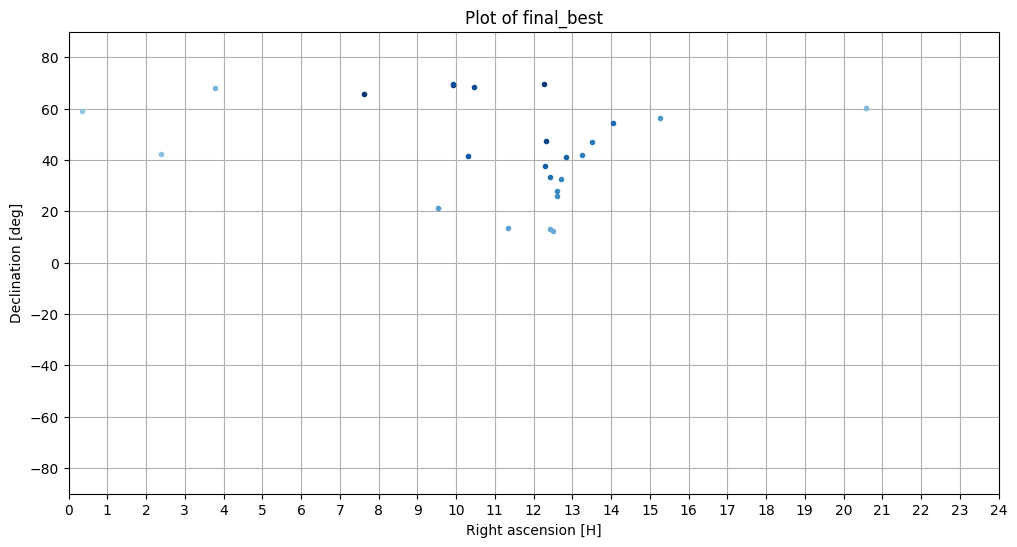

In [71]:
def mapping(objects: list):
    """
    This function plots objects on a Right ascension in hours (0 - 24) and declination (-90° - 90°).

    Parameters
    ----------
    objects: list, List of objects to be plotted
    
    """
    frame = inspect.currentframe().f_back
    possible_names = [name for name, val in frame.f_globals.items() if val is objects]
    array_name = possible_names[0] if possible_names else "Object Map"


    fig,ax = plt.subplots(figsize=(12,6))

    num_points = len(objects)  
    colors = plt.cm.Blues(np.linspace(1, 0.4, num_points))  
    

    for n in range(num_points):
        ax.plot(
            float(objects[n, 1]), 
            float(objects[n, 2]), 
            ".", 
            color=colors[n], 
            label=objects[n, 0] if n < 10 else ""  
        )


    ax.set_xlim(0,360)
    ax.set_ylim(-90,90)
    ax.grid()

    ax.set_xticks(np.linspace(0, 360, 25))
    ax.set_xticklabels([str(int(i)) for i in np.linspace(0, 24, 25)])

    ax.set_title(f"Plot of {array_name}")
    ax.set_ylabel("Declination [deg]")
    ax.set_xlabel("Right ascension [H]")

    plt.show

gal = Galaxies(data_arr)[0]
no_gal = Galaxies(data_arr)[1]

mapping(final_best)



In [38]:
#data_wto_30 = time_over_x(data_arr)

def generate_grid(n: int):
    """
    Generates a 2D grid of n evenly spaced points.
    Column 1: X-coordinates (0 to 360)
    Column 2: Y-coordinates (-90 to 90)
    """
    # Determine approximate grid size (rows and columns)
    num_cols = int(np.sqrt(n * (360 / 180)))  # Keep aspect ratio
    num_rows = n // num_cols  # Compute rows based on total n

    # Create evenly spaced values in both axes
    x_values = np.linspace(0, 360, num_cols)
    y_values = np.linspace(-90, 90, num_rows)

    # Create the 2D grid
    X_grid, Y_grid = np.meshgrid(x_values, y_values)

    # Flatten to get an (n, 2) array
    points = np.column_stack((X_grid.ravel(), Y_grid.ravel()))

    return points

# Example: Generate 1000 points
n = 1000
grid_points = generate_grid(n)


def add_column_of_ones(array):
    """
    Adds a column of ones to the front of a 2D NumPy array.
    """
    n = array.shape[0]  # Number of rows
    ones_column = np.ones((n, 1))  # Create a (n,1) column of ones
    new_array = np.hstack((ones_column, array))  # Prepend ones column
    return new_array

grid_points_one = add_column_of_ones(grid_points)

grid_wto_30 = time_over_x(grid_points_one)

Minimum y-value: 17.052767052767045, Corresponding x-value: 10.33033033033033


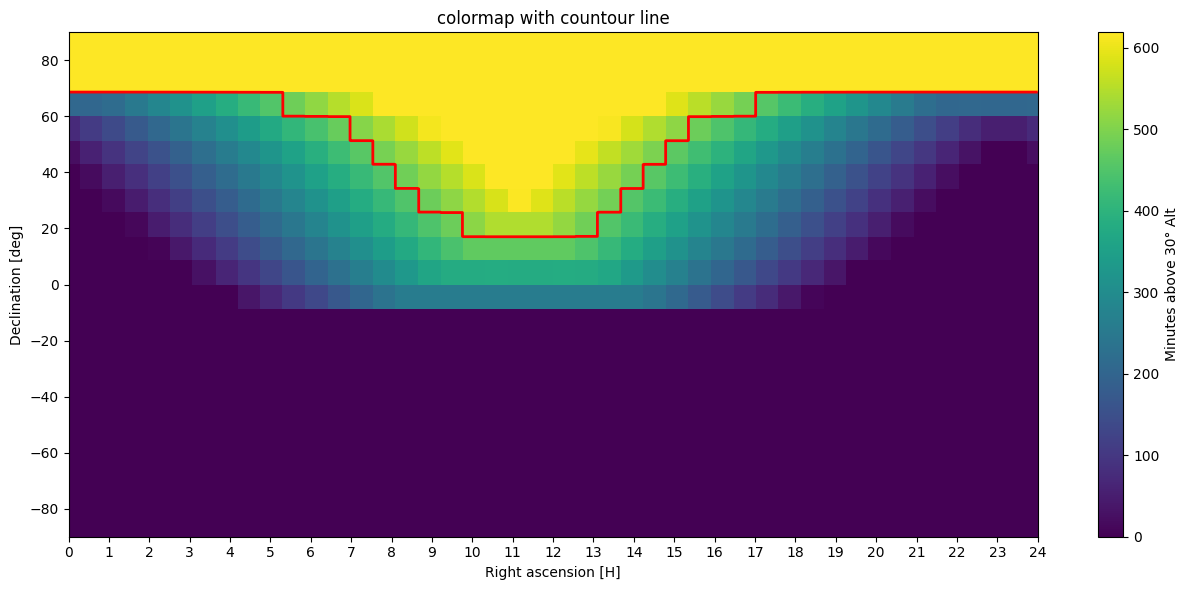

In [69]:
def color_map(data: np.ndarray, t: float, resolution: float):
    """Function that takes arrays with position (RA,DEC) and "time above 30° Alt"(t30) values. And plots them in a colormap. Also plots a contour line for a specifiable t30 t.

    Parameters
    ----------
    data : array, 2D-array with RA-values in 2nd collumn DEC-values in 3rd collumn and no. of minutes above 30° Alt in last collumn. (Rest is irrelevant for this function)
    t : float, minutes-hurdle
    resolution : float, number of gridpoints.
    
    """

    fig, ax = plt.subplots(figsize = (13,6))

    # Convert data to numerical format (fixes the UFuncTypeError)
    X = data[:, 1].astype(float)  # Convert X to float
    Y = data[:, 2].astype(float)  # Convert Y to float
    C = data[:, -1].astype(float) # Convert C to float

    # Create a regular grid
    x_lin = np.linspace(X.min(), X.max(), resolution)  # Adjust resolution if needed
    y_lin = np.linspace(Y.min(), Y.max(), resolution)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)

    # Interpolate C onto the grid
    C_grid = griddata((X, Y), C, (X_grid, Y_grid), method='nearest')
    
    # Plot
    p = ax.pcolormesh(X_grid, Y_grid, C_grid, shading="nearest")
    cbar = fig.colorbar(p, ax=ax)
    cbar.set_label("Minutes above 30° Alt")

    contour = ax.contour(X_grid, Y_grid, C_grid, levels=[t], colors='red', linewidths=2)
    #ax.clabel(contour, fmt="C=120", inline=True, fontsize=10)

    contour_paths = contour.allsegs[0]  # Get all contour paths

    # Store (x, y) points from the contour
    contour_points = np.vstack(contour_paths)

    min_index = np.argmin(contour_points[:, 1])  # Index of min y-value
    min_x, min_y = contour_points[min_index]  # Extract x and y of the minimum

    print(f"Minimum y-value: {min_y}, Corresponding x-value: {min_x/15}")

    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())

    ax.set_xticks(np.linspace(0, 360, 25))
    ax.set_xticklabels([str(int(i)) for i in np.linspace(0, 24, 25)])
    #ax.set_aspect(aspect = 2/2)

    ax.set_title("colormap with countour line")
    ax.set_ylabel("Declination [deg]")
    ax.set_xlabel("Right ascension [H]")

    plt.tight_layout()
    plt.show()

color_map(grid_wto_30, 480, 1000)